In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [17]:
CUDA = torch.cuda.is_available()

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [91]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [92]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [93]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [94]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [95]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [96]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [97]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [98]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [113]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]

In [114]:
if CUDA:
    E.cuda()
    D.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]

In [115]:
import os
os.system('mkdir -p checkpoint')
PATH = 'checkpoint/hd_vae'
def save_model():
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(D.state_dict(), "{}_D".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
#save_model()

In [116]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
if CUDA:
    log_two_pow_n = log_two_pow_n.cuda()

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        sofar = E(x)
        outputs = [O0(sofar)]

        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [117]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-04 *
  4.0340
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [118]:
x

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 4x784 (GPU 0)]

In [119]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/bsize # TODO eddie: changed from size_average=False
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    return BCE, KLD

In [120]:
params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] + [{'params': g.parameters()} for g in Gs]
optimizer = optim.Adam(params, lr=1e-4)

In [121]:
best_loss_sofar = 9999

In [122]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
        bits = torch.cat(samples, dim=1)
        q = prob(outputs)
        recon_x = D(bits)
        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
#         if batch_idx % 200 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 BCE.data[0] / len(data),
#                 KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss

In [123]:
%%time
for epoch in range(5000):
    train(epoch)

====> Epoch: 1 Average BCE loss: 2.3686, Average KLD loss: 0.0124, Total: 2.3809
Loss 2.380908188727977 is better than previous best 9999, saving model
====> Epoch: 2 Average BCE loss: 2.0511, Average KLD loss: 0.0140, Total: 2.0650
Loss 2.06503392410477 is better than previous best 2.380908188727977, saving model
====> Epoch: 3 Average BCE loss: 2.0102, Average KLD loss: 0.0139, Total: 2.0241
Loss 2.0240975508371988 is better than previous best 2.06503392410477, saving model
====> Epoch: 4 Average BCE loss: 2.0020, Average KLD loss: 0.0139, Total: 2.0159
Loss 2.0158843368351462 is better than previous best 2.0240975508371988, saving model
====> Epoch: 5 Average BCE loss: 2.0003, Average KLD loss: 0.0139, Total: 2.0141
Loss 2.014137371867895 is better than previous best 2.0158843368351462, saving model
====> Epoch: 6 Average BCE loss: 1.9986, Average KLD loss: 0.0139, Total: 2.0125
Loss 2.012489681071043 is better than previous best 2.014137371867895, saving model
====> Epoch: 7 Averag

====> Epoch: 55 Average BCE loss: 1.8433, Average KLD loss: 0.0100, Total: 1.8534
Loss 1.8533651951432228 is better than previous best 1.8535187096605699, saving model
====> Epoch: 56 Average BCE loss: 1.8421, Average KLD loss: 0.0099, Total: 1.8520
Loss 1.8519986951490244 is better than previous best 1.8533651951432228, saving model
====> Epoch: 57 Average BCE loss: 1.8446, Average KLD loss: 0.0098, Total: 1.8544
====> Epoch: 58 Average BCE loss: 1.8444, Average KLD loss: 0.0096, Total: 1.8540
====> Epoch: 59 Average BCE loss: 1.8413, Average KLD loss: 0.0096, Total: 1.8509
Loss 1.8509089320898056 is better than previous best 1.8519986951490244, saving model
====> Epoch: 60 Average BCE loss: 1.8430, Average KLD loss: 0.0096, Total: 1.8526
====> Epoch: 61 Average BCE loss: 1.8431, Average KLD loss: 0.0094, Total: 1.8525
====> Epoch: 62 Average BCE loss: 1.8441, Average KLD loss: 0.0094, Total: 1.8535
====> Epoch: 63 Average BCE loss: 1.8432, Average KLD loss: 0.0093, Total: 1.8525
====

====> Epoch: 140 Average BCE loss: 1.7748, Average KLD loss: 0.0080, Total: 1.7828
====> Epoch: 141 Average BCE loss: 1.7731, Average KLD loss: 0.0080, Total: 1.7811
====> Epoch: 142 Average BCE loss: 1.7768, Average KLD loss: 0.0079, Total: 1.7847
====> Epoch: 143 Average BCE loss: 1.7739, Average KLD loss: 0.0080, Total: 1.7819
====> Epoch: 144 Average BCE loss: 1.7762, Average KLD loss: 0.0080, Total: 1.7842
====> Epoch: 145 Average BCE loss: 1.7764, Average KLD loss: 0.0080, Total: 1.7845
====> Epoch: 146 Average BCE loss: 1.7750, Average KLD loss: 0.0080, Total: 1.7830
====> Epoch: 147 Average BCE loss: 1.7768, Average KLD loss: 0.0080, Total: 1.7848
====> Epoch: 148 Average BCE loss: 1.7772, Average KLD loss: 0.0081, Total: 1.7853
====> Epoch: 149 Average BCE loss: 1.7760, Average KLD loss: 0.0080, Total: 1.7841
====> Epoch: 150 Average BCE loss: 1.7799, Average KLD loss: 0.0080, Total: 1.7879
====> Epoch: 151 Average BCE loss: 1.7734, Average KLD loss: 0.0080, Total: 1.7814
====

====> Epoch: 239 Average BCE loss: 1.8379, Average KLD loss: 0.0076, Total: 1.8455
====> Epoch: 240 Average BCE loss: 1.8415, Average KLD loss: 0.0075, Total: 1.8491
====> Epoch: 241 Average BCE loss: 1.8415, Average KLD loss: 0.0075, Total: 1.8490
====> Epoch: 242 Average BCE loss: 1.8448, Average KLD loss: 0.0075, Total: 1.8523
====> Epoch: 243 Average BCE loss: 1.8496, Average KLD loss: 0.0075, Total: 1.8571
====> Epoch: 244 Average BCE loss: 1.8528, Average KLD loss: 0.0076, Total: 1.8604
====> Epoch: 245 Average BCE loss: 1.8509, Average KLD loss: 0.0074, Total: 1.8583
====> Epoch: 246 Average BCE loss: 1.8478, Average KLD loss: 0.0074, Total: 1.8552
====> Epoch: 247 Average BCE loss: 1.8530, Average KLD loss: 0.0075, Total: 1.8604
====> Epoch: 248 Average BCE loss: 1.8560, Average KLD loss: 0.0074, Total: 1.8634
====> Epoch: 249 Average BCE loss: 1.8545, Average KLD loss: 0.0074, Total: 1.8619
====> Epoch: 250 Average BCE loss: 1.8518, Average KLD loss: 0.0073, Total: 1.8591
====

KeyboardInterrupt: 

In [129]:
save_model()

In [124]:
q

Variable containing:
( 0 ,.,.) = 
  5.3655e-04  9.9946e-01
  9.9993e-01  6.8301e-05
  5.0000e-01  5.0000e-01
  9.9700e-01  2.9982e-03
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  9.2188e-01  7.8120e-02
  5.1239e-04  9.9949e-01
  5.0000e-01  5.0000e-01
  1.6578e-03  9.9834e-01
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  2.3924e-03  9.9761e-01
  9.9104e-01  8.9591e-03
  5.0000e-01  5.0000e-01
  6.4412e-01  3.5588e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  3.0953e-01  6.9047e-01
  9.9846e-01  1.5369e-03
  5.0000e-01  5.0000e-01
  9.8760e-01  1.2396e-02
  5.0000e-01  5.0000e-01

(98 ,.,.) = 
  9.9989e-01  1.1406e-04
  3.4793e-01  6.5207e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

(99 ,.,.) = 
  9.9998e-01  1.5706e-05
  9.9994e-01  6.0578e-05
  5.0000e-01  5.0000e-01
  1.0000e+00  3.4921e-06
  5.0000e-01  5.0000e-01
[torch.cuda.FloatTensor of size 100x5x2 (GPU 0)]

In [125]:
bits

Variable containing:
    0     1     0     1     1
    1     0     0     0     1
    0     1     0     0     1
    0     1     1     1     0
    1     1     0     0     1
    0     1     0     1     0
    1     1     1     1     0
    1     0     1     0     1
    1     0     0     0     1
    1     1     1     1     1
    1     0     0     1     1
    0     0     1     0     1
    0     1     1     1     0
    1     1     1     1     0
    0     1     1     0     1
    0     1     0     1     1
    1     1     1     1     0
    0     1     0     1     1
    1     0     0     0     1
    0     1     1     1     1
    0     0     1     0     1
    1     1     0     1     1
    1     1     1     1     1
    0     1     0     1     1
    0     1     0     1     1
    0     1     0     1     0
    1     0     0     0     0
    0     1     1     1     1
    1     1     0     1     0
    1     0     1     0     1
    1     1     1     1     1
    0     1     1     0     0
    1     1     0  

In [126]:
#test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [127]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

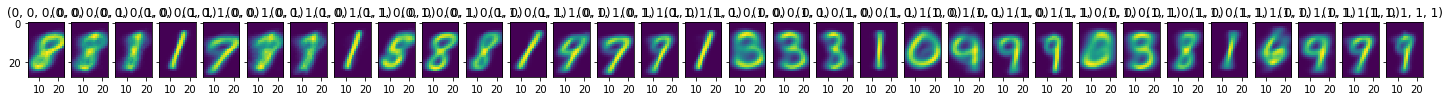

In [128]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
kk = 0
for path in product(range(2), repeat=N):
    v = Variable(torch.Tensor(path).type(torch.FloatTensor))
    if CUDA:
        v = v.cuda()
    w = D.forward(v)
    ax = axes[kk]
    ax.set_title(path)
    ax.imshow(w.view(28,28).cpu().data.numpy())
    kk += 1